## Tijdreeks NDVI-analyse en voorspelling in Google Earth Engine-platform

### 1. Data Loading

In [4]:
import ee, datetime    # Google Earth Engine
import pandas as pd
import numpy as np
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AX4XfWiBWWMZxoIkykdvTYCVqtNh_vP13G5qYMxylQtZ-KsGPvCXOENhHvA

Successfully saved authorization token.


### Selecteer regio

MODIS is een apparaat aan boord van de Terra-satelliet en Aqua-satelliet. Deze twee satellieten draaien meerdere keren per dag om de aarde, waardoor in 1 à 2 dagen de hele aarde is afgescand.

In [6]:
dataset = ee.ImageCollection('MODIS/061/MYD13A2').\
          filterDate('2013-01-01','2021-01-01')   

NL_AOI = ee.Geometry.Rectangle([7.2109,50.7538,53.4658 ,3.3708])
# filtergebied
landsat_AOI = dataset.filterBounds(NL_AOI)

In [7]:

NL_map = folium.Map(location=[52.5,5.5], zoom_start=10)
NL_map

In [8]:
print('Aantal fotos :', landsat_AOI.size().getInfo())


Aantal fotos : 184


### Bandinformatie :

In [9]:
landsat_AOI.first().bandNames().getInfo()


['NDVI',
 'EVI',
 'DetailedQA',
 'sur_refl_b01',
 'sur_refl_b02',
 'sur_refl_b03',
 'sur_refl_b07',
 'ViewZenith',
 'SolarZenith',
 'RelativeAzimuth',
 'DayOfYear',
 'SummaryQA']

In [19]:
ndvi = dataset.select('NDVI')

### 2. NDVI-analyse
NDVI van elke afbeeldingspixel in de afbeeldingen wordt berekend met de vergelijking:

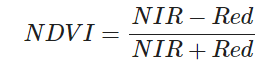
 
 

Waarbij NIR de B5-band is en Rood de B4-band. De gemiddelde NDVI wordt berekend op elke afbeelding om een tijdreeks-NDVI van de AOI te krijgen.

NDVI-berekening

In [20]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Voeg Earth Engine-tekenmethode toe aan folium.
folium.Map.add_ee_layer = add_ee_layer

In [35]:

def addNDVI(image):
    ndvi = image.normalizedDifference(['NDVI','EVI']).rename('NDVI')
    return image.addBands(ndvi)

with_ndvi = landsat_AOI.map(addNDVI)

In [36]:
meanNDVI = ndvi.mean().multiply(0.0001)
vis_params = {
  'min': 0.0,
  'max': 0.5,
'dimensions': 512,
    'region': NL_AOI,
  'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901','66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01','012E01', '011D01', '011301'],
} 
# Definieer het midden van onze kaart
lat, lon = 52.5,5.5

my_map = folium.Map(location=[lat, lon], zoom_start=7)

my_map.add_ee_layer(meanNDVI, vis_params, 'NDVI')

In [37]:
# Voeg een laagcontrolepaneel toe aan de kaart.
my_map.add_child(folium.LayerControl())

# Geef de kaart weer.
display(my_map)

In [67]:
# Functie om 'gemiddelde NDVI' te berekenen op alle afbeeldingen in de collectie

def meanNDVI(image):
    image = ee.Image(image)
    meanDict = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['NDVI']),
        geometry = NL_AOI,
        scale = image.projection().nominalScale().getInfo(),
                                    maxPixels = 100000,
                                    bestEffort = True);
    return meanDict.get('NDVI').getInfo() * 0.0001

In [68]:
#Bereken 'gemiddelde NDVI' voor elke afbeelding
# Duurt van 1 a' 3 minuten ! 
listOfImages_ndvi = with_ndvi.select('NDVI').toList(with_ndvi.size())

ndvi_coll = []

for i in range(listOfImages_ndvi.length().getInfo()):
    image = ee.Image(listOfImages_ndvi.get(i-1))
    temp_ndvi = meanNDVI(image)
    print(temp_ndvi)
    ndvi_coll.append(temp_ndvi)

0.23085390399318956
0.19011890017604868
0.18998483579592082
0.18990574885434328
0.20751320273648266
0.21685209104537803
0.2412898645745967
0.27152456277652415
0.30111665626346507
0.30844911153162097
0.3102068200730258
0.3092013610622699
0.3157743037008527
0.30681916438972934
0.31600693559364135
0.31984743988848136
0.32614238346566143
0.3193483878236193
0.3108088957171522
0.2997712288026636
0.2874895073506242
0.2681462972044432
0.23185403750483152
0.22147154537261718
0.21557919133860975
0.18810852168628667
0.2181413321843584
0.2274145876557855
0.24631975768899167
0.2604517543230562
0.2824064747950572
0.3108693040027952
0.32018027772719354
0.31980517112350426
0.31603302864793253
0.3127925032065438
0.31055887204316296
0.31977883380300337
0.3215881506946064
0.32530175588525
0.3173858510680136
0.31050946110970296
0.2998396866856656
0.2757514536388268
0.24439575051667714
0.24479718653738866
0.20836453064150323
0.2090415242608579
0.2020934182882136
0.19952895366045764
0.21573047372404713
0.22

In [69]:
# Extraheer 'datums' uit de afbeeldingenverzameling

dates = np.array(with_ndvi.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

### Tijdreeks NDVI-dataframe :

In [70]:
#Maak een dataframe met de kolommen 'dag' en 'NDVI'

ndvi_df = pd.DataFrame(ndvi_coll, index = day, columns = ['ndvi'])
ndvi_df.index = pd.to_datetime(ndvi_df.index, format="%Y/%m/%d")
ndvi_df.sort_index(ascending = True, inplace = True)

ndvi_df.head(10)

,ndvi
2013-01-09,0.230854
2013-01-25,0.190119
2013-02-10,0.189985
2013-02-26,0.189906
2013-03-14,0.207513
2013-03-30,0.216852
2013-04-15,0.241290
2013-05-01,0.271525
2013-05-17,0.301117
2013-06-02,0.308449


### Up-sample om dagelijkse NDVI-Data te krijgen
Ons doel is om een algoritme te trainen om NDVI te voorspellen, waarbij de gegevens een regelmatig interval moeten hebben, zoals dagelijks, wekelijks en dergelijke. Het filteren van de gegevens op bewolkingspercentage levert NDVI-gegevens met onregelmatige intervallen op. In deze sectie zullen we upsamplen om dagelijkse NDVI-Data te krijgen met lineaire interpolatie.

In [71]:
# Up-sample van de datumkolom

ndvi_df_daily = ndvi_df.resample('D').median()

# Lineaire interpolatie van NDVI-Data

ndvi_df_daily.interpolate(method='polynomial', order = 1, inplace = True)
ndvi_df_daily.head(10)

,ndvi
2013-01-09,0.230854
2013-01-10,0.228308
2013-01-11,0.225762
2013-01-12,0.223216
2013-01-13,0.220670
2013-01-14,0.218124
2013-01-15,0.215578
2013-01-16,0.213032
2013-01-17,0.210486
2013-01-18,0.207940


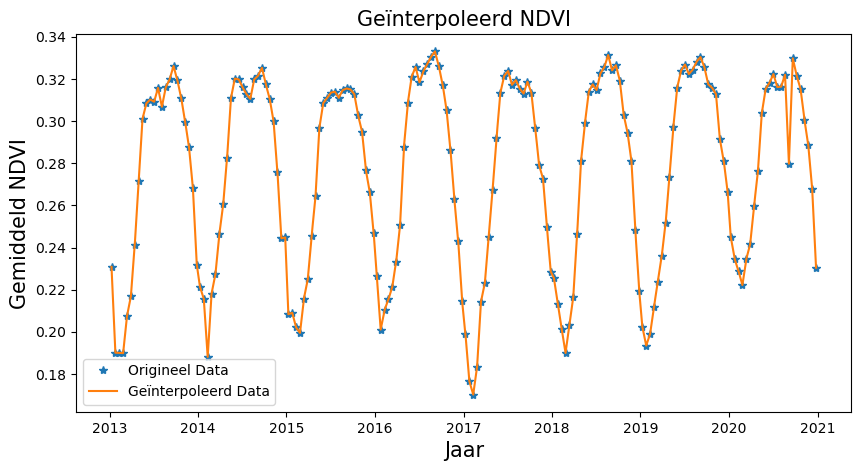

In [72]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(ndvi_df, '*')
plt.plot(ndvi_df_daily)
plt.xlabel('Jaar', fontsize=15)
plt.ylabel('Gemiddeld NDVI', fontsize=15)
plt.legend(['Origineel Data', 'Geïnterpoleerd Data'])
plt.title("Geïnterpoleerd NDVI", fontsize=15)
plt.show()

- Geïnterpoleerde gegevens komen goed overeen met de originele gegevens, wat voldoende is om het algoritme voor voorspelling te trainen


### 3. NDVI-voorspellings : 
Er zijn veel populaire algoritmen voor tijdreeksmodellering, waarvan ARIMA het meest populaire conventionele model is. We zullen dit gebruiken voor NDVI-voorspellingsmodellering.


#### ARIMA-model
ARIMA staat voor Auto Regressive Integrated Moving Average. Algemeen ARIMA-model kan worden uitgedrukt als:

***voorspelde Y(t) = constant + lineaire combinatie lags van Y(t) (p lags) + lineaire combinatie lags van error in voorspellingstermen (q lags)*** 

Er zijn veel manieren om de best mogelijke combinaties van p-, d- en q-waarden te bepalen voor een ARIMA-model op basis van tijdreeksgegevens. Een manier is het handmatig plotten van de automatische correlatiefunctie (ACF) en de gedeeltelijke autocorrelatiefunctie (PACF) voor combinaties van p-, d- en q-parameters en het bepalen van het geval voor bijna nul ACF- en PACF-waarden. Hier zullen we de auto_arima-functie gebruiken die de best geoptimaliseerde modelparameters voor bereiken van p, q-waarden zal uitvoeren op basis van Akaike Information Criterion (AIC). AIC is een schatter die de statistische kwaliteit van een model beoordeelt. Model met een lagere AIC-waarde resulteert in de beste pasvorm met de trainingsgegevens met de minste functies.

De auto_arima-functie kan de rasterzoekopdracht uitvoeren over p, d, q (gerelateerd aan het ARIMA-model) en P, D en Q (gerelateerd aan seizoenscomponenten) en vervolgens het model rapporteren met de beste AIC-waarde.


#### Seizoensgebonden ontbinding
Laten we eens kijken naar de trend- en seizoenscomponenten uit de tijdreeks NDVI-gegevens

- **Trend**: NDVI-tendens over een bepaalde periode. bijv. als de NDVI in de loop van een jaar toeneemt/afneemt
- **Seizoensgebondenheid**: periodieke variatie in de NDVI die we elk jaar zien. Het vertelt in welk deel van het jaar de NDVI toeneemt/afneemt en dat gebeurt cyclisch door de jaren heen
- **residu**: niet-systematische component van de NDVI-waarde die niet is gestructureerd en wordt aangeduid als residu

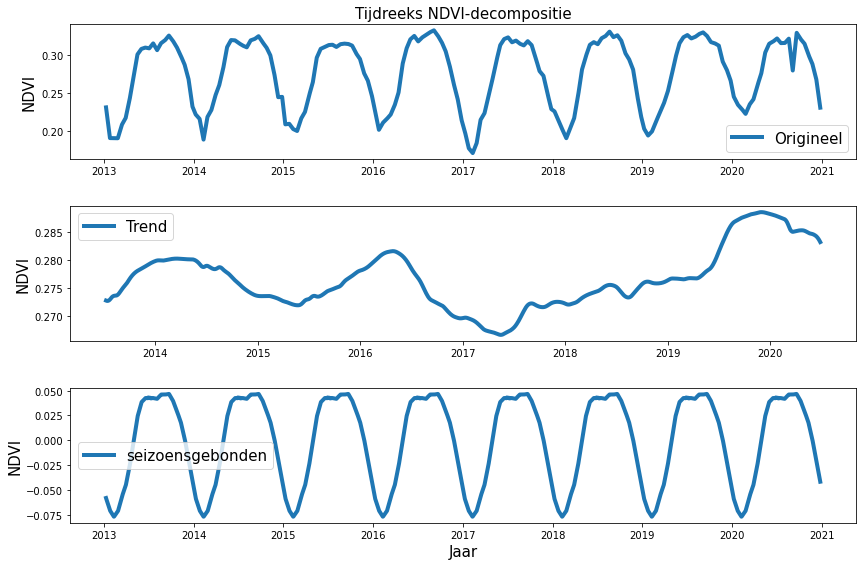

In [73]:
# Apply decompomposition on NDVI data

decomposition = seasonal_decompose(ndvi_df_daily, model= 'additive', period = 365)    # additive werkte beter in termen van seizoensgebonden ontleding
                                                          # vergeleken met vermenigvuldigend

# wijs trend, seizoenscomponenten toe uit ontlede data 

trend = decomposition.trend
seasonal = decomposition.seasonal


# Plot de originele gegevens, de trend, de seizoensgebondenheid en het residu

plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(ndvi_df_daily, label = 'Origineel', linewidth=4)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.title('Tijdreeks NDVI-decompositie', fontsize=15)
plt.subplot(412)
plt.plot(trend, label = 'Trend', linewidth=4)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.subplot(413)
plt.plot(seasonal, label = 'seizoensgebonden', linewidth=4)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.xlabel('Jaar', fontsize=15)
plt.tight_layout()

- De NDVI vertoont een dalende trend van 2017 tot 2019. Van 2019 tot vandaag vertoont deze een stijgende trend. Deze interessante trend zou verder kunnen worden onderzocht om causale verbanden te leggen.
- Seizoensgebondenheid is constant in de tijd, maar volgt een strikt cyclische manier. Dat is elk jaar dat er specifieke momenten zijn waarop NDVI stijgt en daalt.


#### NDVI-trend voor twee jaar

Laten we eens goed kijken naar wat er over twee jaar gebeurt. We zullen een breder beeld hebben van de seizoensinvloeden.

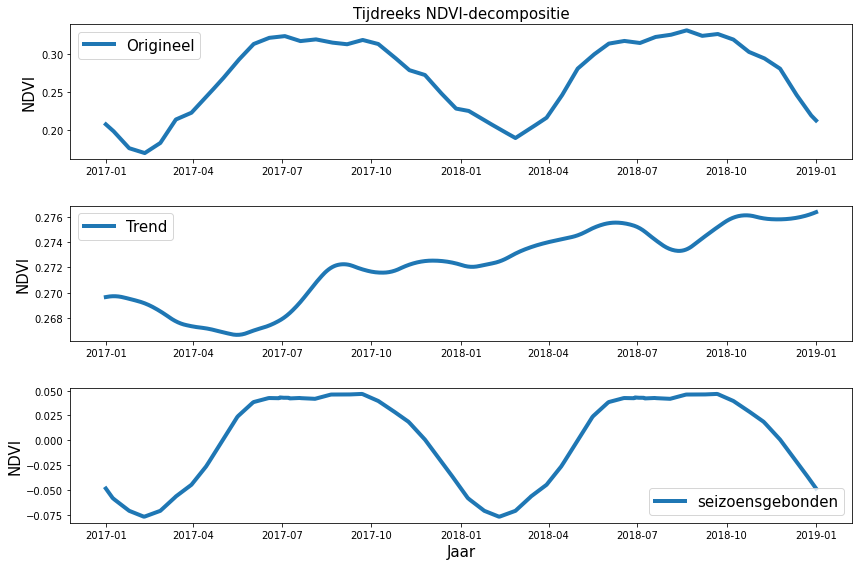

In [74]:
# Plot de originele gegevens, de trend, de seizoensgegevens over twee jaar

two_year = (ndvi_df_daily.index>='2017-01-01') & (ndvi_df_daily.index<='2019-01-01')

plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(ndvi_df_daily[two_year], label = 'Origineel', linewidth=4)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.title('Tijdreeks NDVI-decompositie', fontsize=15)
plt.subplot(412)
plt.plot(trend[two_year], label = 'Trend', linewidth=4)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.subplot(413)
plt.plot(seasonal[two_year], label = 'seizoensgebonden', linewidth=4)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.xlabel('Jaar', fontsize=15)
plt.tight_layout()

Kijkend naar de seizoensinvloeden, is NDVI het laagst tijdens het herfst- en winterseizoen, terwijl het tijdens het zomerseizoen toeslaat.

In [75]:
for i in day:
    print(i)

2013-01-09
2013-01-25
2013-02-10
2013-02-26
2013-03-14
2013-03-30
2013-04-15
2013-05-01
2013-05-17
2013-06-02
2013-06-18
2013-07-04
2013-07-20
2013-08-05
2013-08-21
2013-09-06
2013-09-22
2013-10-08
2013-10-24
2013-11-09
2013-11-25
2013-12-11
2013-12-27
2014-01-09
2014-01-25
2014-02-10
2014-02-26
2014-03-14
2014-03-30
2014-04-15
2014-05-01
2014-05-17
2014-06-02
2014-06-18
2014-07-04
2014-07-20
2014-08-05
2014-08-21
2014-09-06
2014-09-22
2014-10-08
2014-10-24
2014-11-09
2014-11-25
2014-12-11
2014-12-27
2015-01-09
2015-01-25
2015-02-10
2015-02-26
2015-03-14
2015-03-30
2015-04-15
2015-05-01
2015-05-17
2015-06-02
2015-06-18
2015-07-04
2015-07-20
2015-08-05
2015-08-21
2015-09-06
2015-09-22
2015-10-08
2015-10-24
2015-11-09
2015-11-25
2015-12-11
2015-12-27
2016-01-09
2016-01-25
2016-02-10
2016-02-26
2016-03-13
2016-03-29
2016-04-14
2016-04-30
2016-05-16
2016-06-01
2016-06-17
2016-07-03
2016-07-19
2016-08-04
2016-08-20
2016-09-05
2016-09-21
2016-10-07
2016-10-23
2016-11-08
2016-11-24
2016-12-10

In [76]:
# Kies twee datums

low_index = day.index('2017-01-09')
high_index = day.index('2017-12-27')

In [77]:
ndvi_low = ee.Image(listOfImages_ndvi.get(low_index))
ndvi_high = ee.Image(listOfImages_ndvi.get(high_index))

In [78]:
# Plot lage NDVI-afbeelding

palette = ['red', 'yellow', 'green']
ndvi_parameters = {'min': -1,
                   'max': 3,
                   'dimensions': 512,
                   'palette': palette,
                   'region': NL_AOI}
my_map.addLayer(ndvi_low, ndvi_parameters)
my_map

In [79]:
# Plot hoge NDVI-afbeelding

my_map.addLayer(ndvi_high, ndvi_parameters)
my_map

#### Train and Test Data Split
Splits de eerste vijf jaar NDVI-gegevens voor treinstellen en de rest van de drie jaar voor testgegevens.

<AxesSubplot:>

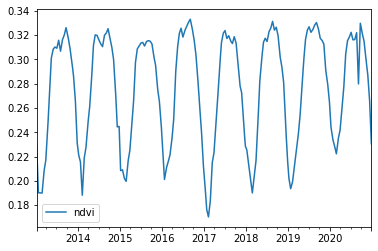

In [80]:
ndvi_df_daily.plot()

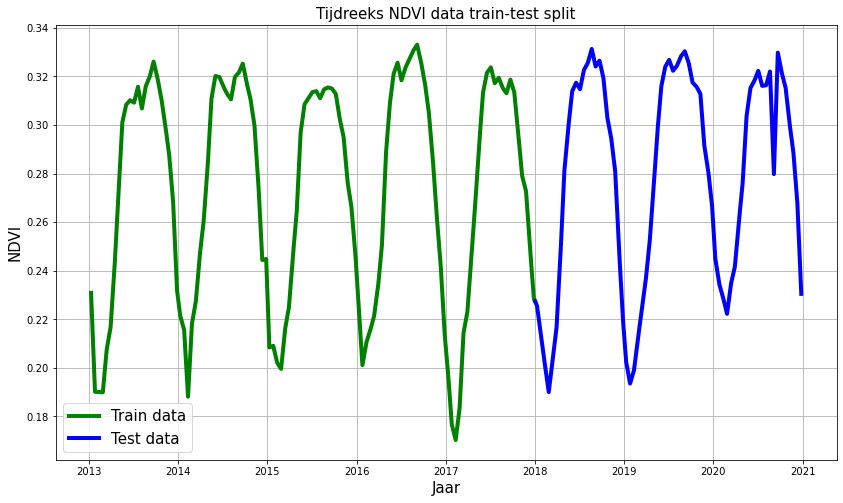

In [81]:
# Data splitsen in trein en trainingsset

 
train_data, test_data = ndvi_df_daily[ndvi_df_daily.index <= '2018-01-01'],\
                        ndvi_df_daily[ndvi_df_daily.index >= '2018-01-01']


# plot de trainings- en testgegevens

plt.figure(figsize=(14,8))
plt.grid(True)
plt.xlabel('Jaar', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.plot(train_data, 'green', label='Train data', linewidth=4)
plt.plot(test_data, 'blue', label='Test data', linewidth=4)
plt.title('Tijdreeks NDVI data train-test split', fontsize=15)

plt.legend(fontsize=15)
plt.show()

#### Train het model
Bepaal de beste parameters om het ARIMA-model te trainen met deze dataset.

In [82]:
# fit auto_arima model

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0, # minimum p, q-waarden
                      test='adf',                              # gebruikt ADF-test om differentiële volgorde 'd' te bepalen
                                                               # nodig voor stationariteit
                      max_p=3, max_q=3,                        # maximale p- en q-waarden
                      m=7,                                    # frequentie van series, m=7 voor dagelijkse observatie
                      d=1,                                    # een stap differentiërend, d=1 kan de gegevens stationair maken
                                                               # gezien vanaf de voorbewerkingsstap
                      seasonal=True,                           # observed seasonality
                      start_P=0,                               
                      D=0,                                     # auto_arima komt terug met optimale P-, Q- en D-parameters
                                                               # wanneer de 'seizoensgebonden' parameter is ingeschakeld
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)                          # stap vs parallel. step wordt aanbevolen voor snellere prestaties

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-20825.762, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-19912.771, Time=0.75 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-24535.704, Time=1.26 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-22002.889, Time=2.74 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-19914.765, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-25452.793, Time=1.00 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=-22326.111, Time=1.33 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-24379.161, Time=1.99 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=-25451.046, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-25451.006, Time=1.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-20907.523, Time=1.02 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=-24157.873, Time=1.83 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=-25454.944, Time=0.38 sec
 ARIMA(1,1,0)(1,0,0)[7]             : AIC=-24538.363, Time=0.88 sec
 ARIM

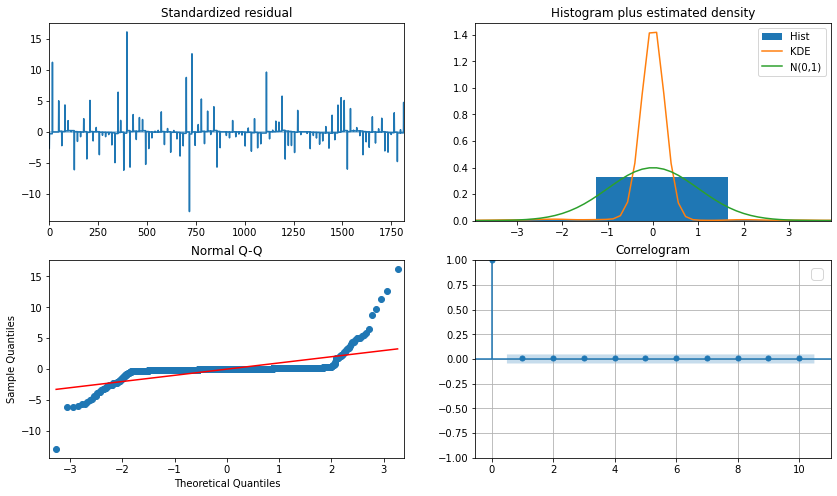

In [83]:
# Laten we de resterende statistieken van het auto ARIMA-model bekijken
# residuen moeten dichter bij ruisachtige statistieken liggen, wat bevestigt dat ze geen informatie uit de gegevens bevatten

model_autoARIMA.plot_diagnostics(figsize=(14,8))
plt.grid(True)
plt.legend(fontsize=15)
plt.show()

#### waarnemingen:

***Linksboven***: restwaarden lijken te schommelen rond nulwaarden en uniforme variantie.

***Rechtsboven***: de dichtheidsplot suggereert gelijkenis van de resterende verdeling (oranje kleur) met de normale verdeling (groene), met een gemiddelde nul.

***Linksonder***: de blauwe stippen moeten perfect aansluiten op de rode lijn voor een ideaal scenario. Dit is de best mogelijke afstemming die we met de gegevens kunnen krijgen.

***Rechtsonder***: de ACF van residuen zijn niet gecorreleerd met de plot (behalve een lichte piek bij 3). Elke correlatie zou suggereren dat er een restpatroon in de gegevens is dat niet in het model wordt uitgelegd en parameteraanpassing vereist
Over het algemeen lijkt het een goed model en klaar voor gebruik voor forecasting.

In [84]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train_data, order=(2,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                   ndvi   No. Observations:                 1819
Model:                 ARIMA(2, 1, 0)   Log Likelihood               12729.603
Date:                Wed, 18 May 2022   AIC                         -25453.206
Time:                        01:28:13   BIC                         -25436.689
Sample:                    01-09-2013   HQIC                        -25447.112
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9861      0.002    456.219      0.000       0.982       0.990
ar.L2         -0.0121      0.002     -5.614      0.000      -0.016      -0.008
sigma2      4.828e-08   3.39e-10    142.573      0.0

In [85]:
fc =fitted.forecast(len(test_data), alpha=0.05) 


#### Model Performance
Model performance worden geëvalueerd door voorspelde waarden te vergelijken met testgegevens. Er zal een vergelijking worden gemaakt in termen van Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE). Het gemiddelde van deze statistieken wordt genomen en wordt 'average_score' genoemd om een idee te krijgen van de algehele overeenstemming van de voorspelling met testgegevens.

In [86]:
# function to report back the performance metrics of a function

def performance_measure(model, yhat, y):
    # mean squared error
    mse = mean_squared_error(y, yhat)
    #mean absolute error
    mae = mean_absolute_error(y, yhat)
    # root mean squared error
    rmse=np.sqrt(mse)
    #average score
    average=np.mean((mse, mae, rmse))
    # save model performance as dataframe
    metrics=pd.DataFrame({'model': model, 'mse': [mse], 'mae': [mae], 'rmse': [rmse], 'average_score':[average]})
    return metrics

In [87]:
# performance measures for the ARIMA model
fc_ARIMA = fc

ARIMA = performance_measure('ARIMA', fc_ARIMA, test_data)
ARIMA


,model,mse,mae,rmse,average_score
0,ARIMA,0.005698,0.065269,0.075487,0.048818


### FBProphet Modelling 
Klassieke forecasting model zoals ARIMA hebben veel parameterafstemming en deskundige kennis op het gebied van statistiek en analyse nodig. Facebook ontwikkelde een open source bibliotheek genaamd FBProphe, die zeer weinig domeinkennis vereist en eenvoudig te integreren is in een geautomatiseerde productieomgeving. FBProphe ontleedt alle tijdreeksgegevens in trend-, seizoens-, gebeurtenis- of vakantiecomponenten en kan worden geschreven als:

Y(t) = T(t) + S(t) + H(t) + e

T(t): stuksgewijs lineaire of logistische groeicurve voor het modelleren van trendcomponenten S(t): cyclische veranderingen in de tijdreeks (dagelijks/wekelijks/maandelijks/kwartaal) H(t): effect van vakanties of ongeplande gebeurtenissen e: rumoerige term die niet kan worden gemodelleerd met vergelijking

In tegenstelling tot op tijd gebaseerde afhankelijkheid, beschouwt FBProphe prognoses als een probleem voor het aanpassen van de curve.

In deze sectie zal FBProphet worden gebruikt om de Nederlandse NDVI-voorspelling te modelleren. Modellering zal beperkt blijven tot een basismodel, maar het kan worden uitgebreid door krachtige tools te integreren die FBProphet biedt, zoals het overwegen van verzadigende groei, trendverandering en speciale evenementen.

In [88]:
# rearrange data to suit Prophet model

# rename columns from date and close to ds and y

train_data_fb = train_data.reset_index()
train_data_fb.rename(columns={"index": "ds", "ndvi": "y"},inplace=True)
train_data_fb.head(5)

,ds,y
0,2013-01-09,0.230854
1,2013-01-10,0.228308
2,2013-01-11,0.225762
3,2013-01-12,0.223216
4,2013-01-13,0.220670


In [91]:
# Build the model


m1=Prophet(interval_width=0.95, daily_seasonality=False, # interval_width = confidence interval
           changepoint_range=0.7,                        # % of train data to look for change point
                                          # (default value is 0.8) 0.7 produced better model performance
           changepoint_prior_scale=0.3)   # determines trend flexibility. tuned around the value (default value is 0.05),
                                          # 3 produced best performance

m1.fit(train_data_fb)

# number of days to forecast, based on test_data

forecast_days = (test_data.index[-1]-test_data.index[0]).days

# Create dataframe with the dates we want to predict

future = m1.make_future_dataframe(periods = forecast_days, freq = 'D')

# Predict the price

forecast = m1.predict(future)

<Figure size 1200x500 with 0 Axes>

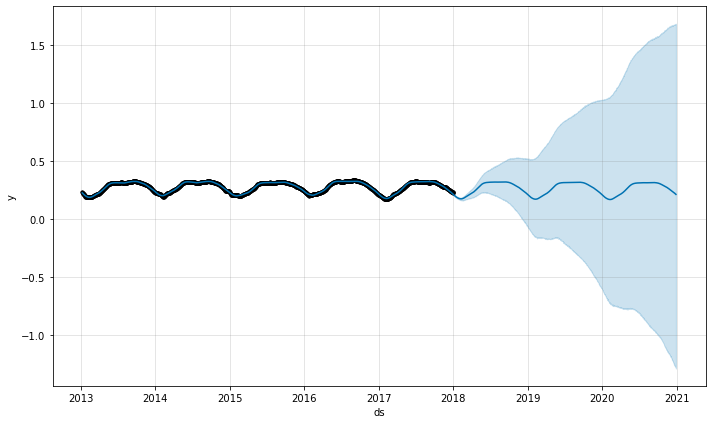

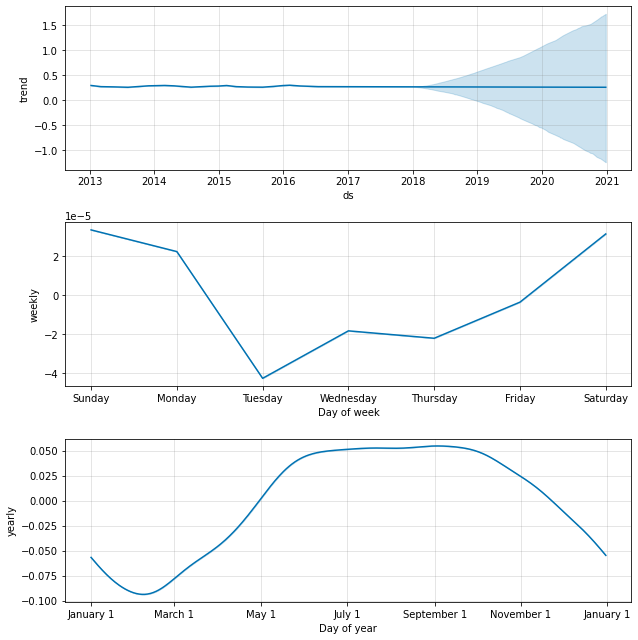

In [92]:
# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m1.plot(forecast)
fig = m1.plot_components(forecast)

plt.grid(True)
plt.show()

## CBS Data 


In [62]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cbsodata 
import geopandas as gpd

In [63]:
# Downloading table list
# Downloading entire dataset (can take up to 30s)
toc = pd.DataFrame(cbsodata.get_table_list())

#Gezonhied monitoren
gezondhied_df = pd.DataFrame(cbsodata.get_data('85012NED'))

boedem_df = pd.DataFrame(cbsodata.get_data('70262ned'))

In [64]:
boedem_df.columns

Index(['ID', 'RegioS', 'Perioden', 'TotaleOppervlakte_1',
       'TotaalVerkeersterrein_2', 'Spoorterrein_3', 'Wegverkeersterrein_4',
       'Vliegveld_5', 'TotaalBebouwdTerrein_6', 'Woonterrein_7',
       'TerreinVoorDetailhandelEnHoreca_8',
       'TerreinVoorOpenbareVoorzieningen_9',
       'TerreinVoorSociaalCultureleVoorz_10', 'Bedrijventerrein_11',
       'TotaalSemiBebouwdTerrein_12', 'Stortplaats_13',
       'Wrakkenopslagplaats_14', 'Begraafplaats_15', 'Delfstofwinplaats_16',
       'Bouwterrein_17', 'SemiVerhardOverigTerrein_18',
       'TotaalRecreatieterrein_19', 'ParkEnPlantsoen_20', 'Sportterrein_21',
       'Volkstuin_22', 'DagrecreatiefTerrein_23',
       'VerblijfsrecreatiefTerrein_24', 'TotaalAgrarischTerrein_25',
       'TerreinVoorGlastuinbouw_26', 'OverigAgrarischTerrein_27',
       'TotaalBosEnOpenNatuurlijkTerrein_28', 'Bos_29',
       'OpenDroogNatuurlijkTerrein_30', 'OpenNatNatuurlijkTerrein_31',
       'TotaalBinnenwater_32', 'IJsselmeerMarkermeer_33',
       

In [65]:
boedem_df = boedem_df[['RegioS','Perioden','Spoorterrein_3','OpenNatNatuurlijkTerrein_31','Bos_29','TotaalBosEnOpenNatuurlijkTerrein_28','OpenDroogNatuurlijkTerrein_30']].replace(True)

In [66]:
boedem_df.drop_duplicates(subset = 'RegioS', keep = 'last',inplace = True)

In [67]:
boedem_df.dropna(inplace = True)

In [68]:
obesitas_df = gezondhied_df[['RegioS','Ondergewicht_7','NormaalGewicht_8','MatigOvergewicht_10','Overgewicht_9','ErnstigOvergewichtObesitas_11']]

In [69]:
obesitas_df.drop_duplicates(subset = 'RegioS', keep = 'last',inplace = True)

C:\Users\hasso\AppData\Local\Temp\ipykernel_19056\3451437963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obesitas_df.drop_duplicates(subset = 'RegioS', keep = 'last',inplace = True)


In [70]:
obesitas_df.dropna(inplace = True)

C:\Users\hasso\AppData\Local\Temp\ipykernel_19056\4020015281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obesitas_df.dropna(inplace = True)


In [71]:
obesitas_df = obesitas_df.merge(boedem_df, on = 'RegioS', how = 'outer')

In [72]:
obesitas_df.dropna(inplace = True)

In [73]:
obesitas_df

,RegioS,Ondergewicht_7,NormaalGewicht_8,MatigOvergewicht_10,Overgewicht_9,ErnstigOvergewichtObesitas_11,Perioden,Spoorterrein_3,OpenNatNatuurlijkTerrein_31,Bos_29,TotaalBosEnOpenNatuurlijkTerrein_28,OpenDroogNatuurlijkTerrein_30
0,Nederland,1.2,40.6,41.5,58.8,17.5,2015,8885.0,62631.0,341270.0,498956.0,95055.0
1,Noord-Nederland (LD),1.2,40.6,43.1,60.0,17.6,2015,1121.0,24910.0,50292.0,103062.0,27861.0
2,Oost-Nederland (LD),1.1,39.8,42.2,60.3,18.5,2015,2274.0,13186.0,144799.0,185016.0,27032.0
3,West-Nederland (LD),1.3,42.1,40.8,57.5,17.0,2015,3765.0,16755.0,43368.0,89614.0,29491.0
4,Zuid-Nederland (LD),1.1,39.4,42.7,60.4,18.1,2015,1725.0,7780.0,102811.0,121263.0,10671.0
...,...,...,...,...,...,...,...,...,...,...,...,...
356,Zundert,3.2,44.4,47.9,64.4,21.1,2015,0.0,179.0,1200.0,1586.0,208.0
357,Zutphen,2.3,47.4,44.6,60.3,19.4,2015,33.0,42.0,579.0,623.0,4.0
358,Zwartewaterland,1.8,37.0,50.7,70.7,24.1,2015,0.0,339.0,127.0,501.0,35.0
359,Zwijndrecht,2.4,40.1,49.3,67.0,21.6,2015,120.0,23.0,45.0,68.0,0.0


## Groenindex data 

In [74]:
groenindex_df = pd.read_excel('ranglijst_groenste_gemeente (1).xlsx')

In [75]:
groenindex_df.rename(columns = {'Gemeentenaam':'RegioS', 'Groenindex':'NDVI'}, inplace = True)

In [76]:
groenindex_df.drop(columns=['Oppervlakte']).inplace = True

In [146]:
groenindex_df

,RegioS,Oppervlakte,NDVI,Ranglijst
0,Bellingwedde,110088936,0.6065,1
1,Rozendaal,27919889,0.6007,2
2,Vlagtwedde,170556626,0.5930,3
3,Aa en Hunze,278874903,0.5858,4
4,Westerveld,282739160,0.5833,5
...,...,...,...,...
383,Zandvoort,43970715,0.3382,384
384,Katwijk,31146532,0.3364,385
385,Beverwijk,20086771,0.3311,386
386,Velsen,63171173,0.3102,387


In [77]:
obesitas_df = obesitas_df.merge(groenindex_df, on = 'RegioS', how = 'outer')

In [78]:
obesitas_df.dropna(inplace = True)

In [79]:
obesitas_df

,RegioS,Ondergewicht_7,NormaalGewicht_8,MatigOvergewicht_10,Overgewicht_9,ErnstigOvergewichtObesitas_11,Perioden,Spoorterrein_3,OpenNatNatuurlijkTerrein_31,Bos_29,TotaalBosEnOpenNatuurlijkTerrein_28,OpenDroogNatuurlijkTerrein_30,Oppervlakte,NDVI,Ranglijst
16,Aa en Hunze,2.2,46.3,46.7,62.3,19.5,2015,0.0,574.0,5133.0,6605.0,898.0,278874903.0,0.5858,4.0
17,Aalsmeer,2.3,51.3,44.9,56.9,15.2,2015,0.0,90.0,47.0,138.0,0.0,32286067.0,0.3794,368.0
18,Aalten,2.4,46.6,45.4,61.7,20.1,2015,11.0,2.0,411.0,416.0,2.0,97053772.0,0.4886,94.0
19,Achtkarspelen,2.6,40.0,50.0,69.3,24.5,2015,22.0,228.0,59.0,289.0,2.0,103980832.0,0.5063,63.0
20,Alblasserdam,2.8,43.8,45.9,63.7,21.7,2015,0.0,5.0,13.0,18.0,0.0,10060081.0,0.3576,379.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,Zundert,3.2,44.4,47.9,64.4,21.1,2015,0.0,179.0,1200.0,1586.0,208.0,121207155.0,0.4195,295.0
338,Zutphen,2.3,47.4,44.6,60.3,19.4,2015,33.0,42.0,579.0,623.0,4.0,42934421.0,0.4736,137.0
339,Zwartewaterland,1.8,37.0,50.7,70.7,24.1,2015,0.0,339.0,127.0,501.0,35.0,87856893.0,0.4085,321.0
340,Zwijndrecht,2.4,40.1,49.3,67.0,21.6,2015,120.0,23.0,45.0,68.0,0.0,22774743.0,0.3976,341.0


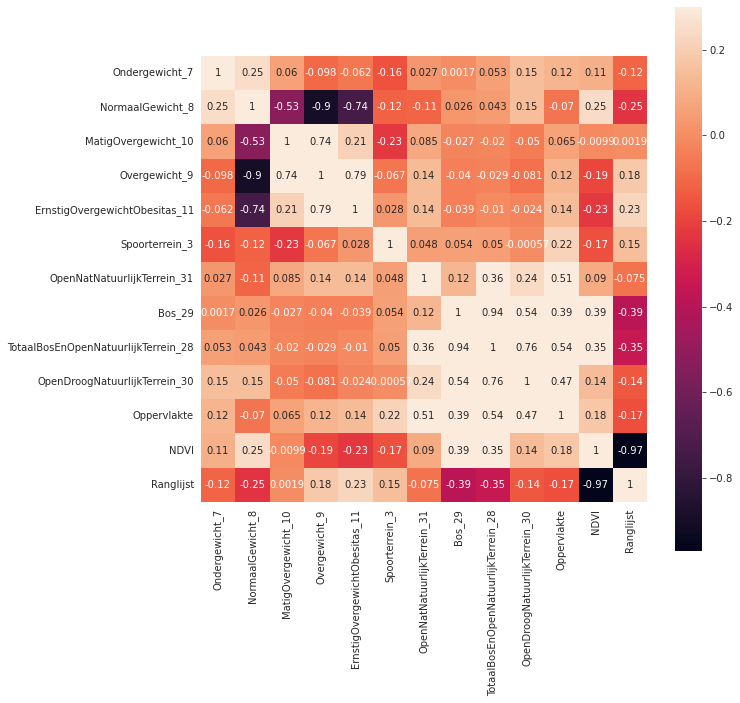

In [87]:
corrMatrix= obesitas_df.corr()

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corrMatrix, annot=True, vmax=.3, square=True)